# Using the NOMAD web API interface

In this tutorial you are going to learn how to:

<div class="alert alert-block alert-warning">
    
**[Writing a NOMAD query](#Writing-a-NOMAD-query)**

**[Querying the NOMAD API](#Querying-the-NOMAD-API)**

**[Analyzing the data](#Analyzing-the-data)**

**[Automatic processing](#Automatic-processing)**
   
</div>

Let's get started!

In [1]:
# imports
from simdatframe.apis.NOMAD_web_API import API, get_atoms
from simdatframe.utils import resolve_nested_dict

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import electron_volt

## Writing a NOMAD query

To download data, we have to query the [NOMAD service](https://nomad-lab.eu). To do so, you can use the [NOMAD documentation](https://nomad-lab.eu/prod/v1/staging/docs/tutorial/access_api.html), or the GUI copy the query over. In this example, we query for bulk GaP structures calculated with DFT using a hybrid functional.

In [2]:
query = {
    "results.material.structural_type:any": [
      "bulk"
    ],
    "results.method.simulation.dft.xc_functional_type:any": [
      "hybrid"
    ],
    "datasets.dataset_name:any": [
      "reproducibility_of_HSE"
    ],
    "results.material.elements:all": [
      "Ga",
      "P"
    ],
    "results.properties.available_properties:all": [
      "dos_electronic"
    ]
}

The NOMAD API requires that we specify which data is requested. For our initial query, we want all data, therefore we define:

In [3]:
required = {"required" : "*"}

## Querying the NOMAD API

To start quering NOMAD, we first import and initialize an API object:

In [4]:
from simdatframe.apis.NOMAD_web_API import API
api = API()

In order to reduce traffic, we just download a single entry:

In [5]:
full_archives = api.get_calculations_by_search(query, # defined above 
                                               required=required, # defined above 
                                               max_entries=1) # one entry only

Found 5 entries
Finished download.


In [6]:
len(full_archives)

1

## Analyzing the data

We can inspect some properties of the `Material` object that we just created: 

In [7]:
example_material = full_archives[0]
print(example_material)

Material(mid = FIUqPOMua13ySJrnOynrNDnT5Xge, data = {'archive'}, properties = set())


In the `data` attribute of the material we now find the full NOMAD archive entry. We can explore its contents to automatically extract the data we need. The atomic structure has been parsed already by default and can be visualized:

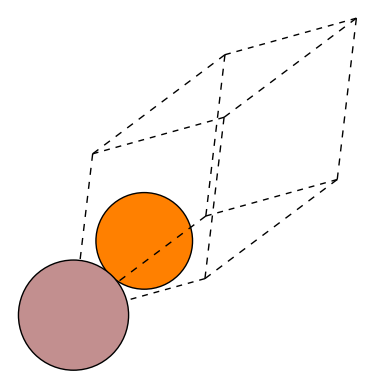

In [8]:
from simdatframe.plotting import plot_material

plot_material(example_material, repeat=[1,1,1], show_unit_cell=2)

To build the automatic parsers of the NOMAD Archive entries, we can inspect the contents of the Archive. For this example, we want to obtain the total energy of the material. To do so, we need to parse the `workflow` section of the Archive:

In [9]:
example_material.data['archive'].keys()

dict_keys(['processing_logs', 'run', 'workflow', 'metadata', 'results', 'm_ref_archives'])

In [10]:
example_material.data["archive"]["workflow"]

[{'type': 'single_point',
  'calculation_result_ref': '/run/0/calculation/0',
  'calculations_ref': ['/run/0/calculation/0'],
  'task': [{'input_workflow': '/workflow/0',
    'output_calculation': '/run/0/calculation/0'},
   {'output_workflow': '/workflow/0',
    'input_calculation': '/run/0/calculation/0'}],
  'single_point': {'method': 'DFT',
   'n_scf_steps': 25,
   'final_scf_energy_difference': 1.393893669254168e-25,
   'is_converged': True,
   'with_density_of_states': True,
   'with_bandstructure': False,
   'with_eigenvalues': True,
   'with_volumetric_data': False,
   'with_excited_states': False}}]

From this list, we choose the first (only) entry, which is a single point calculation. From the workflow, we can extract the reference to the result:

In [11]:
example_material.data["archive"]["workflow"][0]["calculation_result_ref"]

'/run/0/calculation/0'

If we manually navigate this path in our Archive entry, we find a value for the total energy (in units of Joule):

In [12]:
example_material.data['archive']['run'][0]['calculation'][0]['energy']['total']['value']

-1.9285848977220246e-18

We can automatize this process by writing a small function:

In [13]:
def get_total_energy(archive: dict) -> float:
    archive=archive['archive']
    energy_ref = resolve_nested_dict(archive, 'workflow/0/calculation_result_ref')
    energy_ref = energy_ref.strip().strip("/") + '/energy/total/value'
    energy = resolve_nested_dict(archive, energy_ref, fail_on_key_error=True)
    return energy / electron_volt

Using this function, we can directly access the total energy (in eV).

In [14]:
get_total_energy(full_archives[0].data)

-12.037280139999998

## Automatic processing

We can now automatize what we did before. To do so, we define a dictionary `processing`, which contains as keys the name of the quantity we want to obtain, and the function to extract them from the NOMAD data as values:

In [15]:
processing = {
    'atoms' : get_atoms, # 'atoms' is predefined here and is expected to return an ase Atoms object
    'energy_total' : get_total_energy,
}

Since we don't need all parts of the NOMAD data anymore, we can adapt the `required` dictionary:

In [16]:
required_processed = {
    "required" : {
        "workflow" : "*", # contains which calculation has the optimized total energy 
        "run" : "*", # contains the total energy value
        "results" : "*" # contails the atomic structure
    }
}

Then we create a new `API` object, to download and process only the data we need:

In [17]:
api_modified = API(processing=processing)

We can run the query:

In [18]:
materials = api_modified.get_calculations_by_search(query, required=required_processed)
for material in materials:
    print(material)

Found 5 entries
Finished download.
Material(mid = FIUqPOMua13ySJrnOynrNDnT5Xge, data = {'energy_total'}, properties = set())
Material(mid = l4YBhD_KzKalkX8cvDJ9oTIHSgZg, data = {'energy_total'}, properties = set())
Material(mid = MDy6puRcMwjin26GFGaIoWuyTZw5, data = {'energy_total'}, properties = set())
Material(mid = 3WER3GH6byHNIUQTOWxNf_vhlA28, data = {'energy_total'}, properties = set())
Material(mid = MawJNfJFAVzVaZkOfsTJnWws0wmp, data = {'energy_total'}, properties = set())


From the available data, we can plot the equation of state (EOS) as a function of the unit cell volume: 

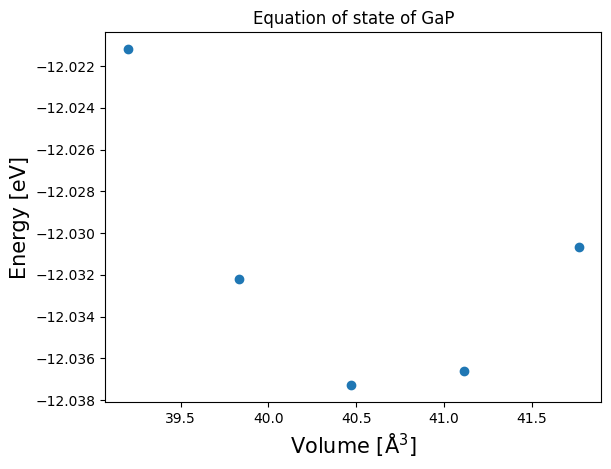

In [19]:
volumes = []
total_energies = []
for mat in materials:
    volumes.append(mat.atoms.get_volume())
    total_energies.append(mat.data['energy_total'])
plt.scatter(volumes, total_energies)
plt.xlabel("Volume [Å$^3$]", fontsize=15)
plt.ylabel("Energy [eV]", fontsize=15)
plt.title("Equation of state of GaP")
plt.show()